# Generating names dataset

Here we will generate names dataset. Names dataset is supposed to be list of names.

In [1]:
%load_ext autoreload
%autoreload 2

In [83]:
import re
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


In [ ]:
file_lists=['/notebooks/nlp_deeplearning/charmodel/data/first_names.all.txt']

names_list = []
with open(file_lists[0],'r') as file:
    for name in file.read().splitlines()[1:]:
        filtered_name = re.sub(r'\W+', '', name)
        names_list.append(filtered_name.upper())

In [ ]:
names_list[:5]

## Load data

In [3]:
import sys
sys.path.insert(0,'/notebooks/Projects/Seq2Seq')
sys.path.insert(0, '../')
sys.path.insert(0,'../runs')

In [4]:
from mllib.seq2seq.namegen import *
from dotmap import DotMap
from mllib.seq2seq.model import *
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers.neptune import NeptuneLogger
import pytorch_lightning as pl



In [ ]:
dsrc = get_dataset(names_list)


# Modelling

In [ ]:
hparams = DotMap({'vocab_size': len(dsrc.vocab), 
          'embedding_size': 30,
          'hidden_size': 300,
            'max_len': 15,
            'num_layers':2,
            'lr': 0.02})


# Training

In [ ]:

neptune_logger = NeptuneLogger(
    api_key="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIwYWY0OTQ4MS03MGY4LTRhNjUtOTFlZC0zZjVjMjlmZGQxNjQifQ==",
    project_name="puneetgirdhar.in/charnn")

tensorboard_logger = TensorBoardLogger("tb_logs", name="my_model")

In [ ]:
dls = dsrc.dataloaders(after_item=after_item, before_batch=pad_input_chunk_new, bs=32, n_inp=2)

# make sure that we use serializing option to instantiate the model

model = RNN(hparams, char2tensor = str(dict(dls.numericalize.o2i)), vocab=str(dls.numericalize.vocab))

checkpoint_callback = ModelCheckpoint(
    dirpath = './checkpoints',
    filename='{epoch}',
    save_top_k=3,
    monitor='val_loss',
    mode='min'
)


trainer = pl.Trainer(fast_dev_run=False, logger=neptune_logger, auto_lr_find='learning_rate',gpus=1,
                    callbacks=[EarlyStopping(monitor='val_loss',patience=5), checkpoint_callback],
                    )

In [ ]:
trainer.fit(model, dls.train, dls.valid)

# Evaluation

Now, we can generate some names randomly

In [ ]:
md = get_first_name_model()

In [ ]:
md.cuda()

In [ ]:
md.generate("CHRIS")

# Bert Transformer

Here is an example to use custom bert transformer for seq 2 seq task. I trained the model for German to english translation.

In [57]:
import torch
import spacy

from mllib.bert import *
from runs.run_bert import *
import spacy


device = torch.device('cpu')

In [58]:

model = LITTransformer.load_from_checkpoint("~/trainer.ckpt")

In [59]:
dm = MyDataModule(batch_size=1)

In [62]:
dm.prepare_data()
dm.setup()

100%|██████████| 29000/29000 [00:01<00:00, 22439.71lines/s]


In [72]:
src = dm.train_data.data[0][0]
trg = dm.train_data.data[0][1]

nlp = spacy.load('de_core_news_sm')
src = [token.text.lower() for token in nlp(src)]

nlp = spacy.load("en_core_web_sm")
trg = [token.text.lower() for token in nlp(trg)]

In [75]:
def translate_sentence(sentence, src_vocab, trg_vocab, model, device, max_len=50):
    model.eval()
    BOS_IDX = src_vocab['<bos>']
    EOS_IDX = trg_vocab['<pad>']

    if isinstance(sentence, str):
        nlp = spacy.load('de_core_news_sm')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]
    
    src_indices = [BOS_IDX] + [src_vocab.stoi[token] for token in tokens] + [EOS_IDX]
    
    src_tensor = torch.LongTensor(src_indices).unsqueeze(0).to(device)
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)
        
    trg_indices = [BOS_IDX]
    for i in range(max_len):
        trg_tensor = torch.LongTensor(trg_indices).unsqueeze(0).to(device)
        trg_mask = model.make_trg_mask(trg_tensor)
    
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, src_mask, trg_mask)
            
            
            pred_token = output.argmax(2)[:,-1].item()
            
            trg_indices.append(pred_token)
            
            if pred_token == EOS_IDX:
                break
            
    trg_tokens = [trg_vocab.itos[i] for i in trg_indices]
    
    return trg_tokens[1:], attention
                                                              

In [76]:
translation, attention = translate_sentence(src, dm.src_vocab, dm.trg_vocab, model.model, device)
#translation

In [81]:
def display_attention(sentence, translation, attention, n_heads= 8, n_rows= 4, n_cols=2):
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(15, 25))
    for i in range(n_heads):
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()
        
        cax = ax.matshow(_attention, cmap='bone')
        
        ax.tick_params(labelsize=12)
        ax.set_xticklabels([''] + ['<bos>'] + [t.lower() for t in sentence] + ['<eos>'], rotation=45)
        ax.set_yticklabels([''] + translation)
        
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
        
    plt.show()
    plt.close()
        

<ipython-input-81-3b3c3a1182ac>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + ['<bos>'] + [t.lower() for t in sentence] + ['<eos>'], rotation=45)
<ipython-input-81-3b3c3a1182ac>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + translation)


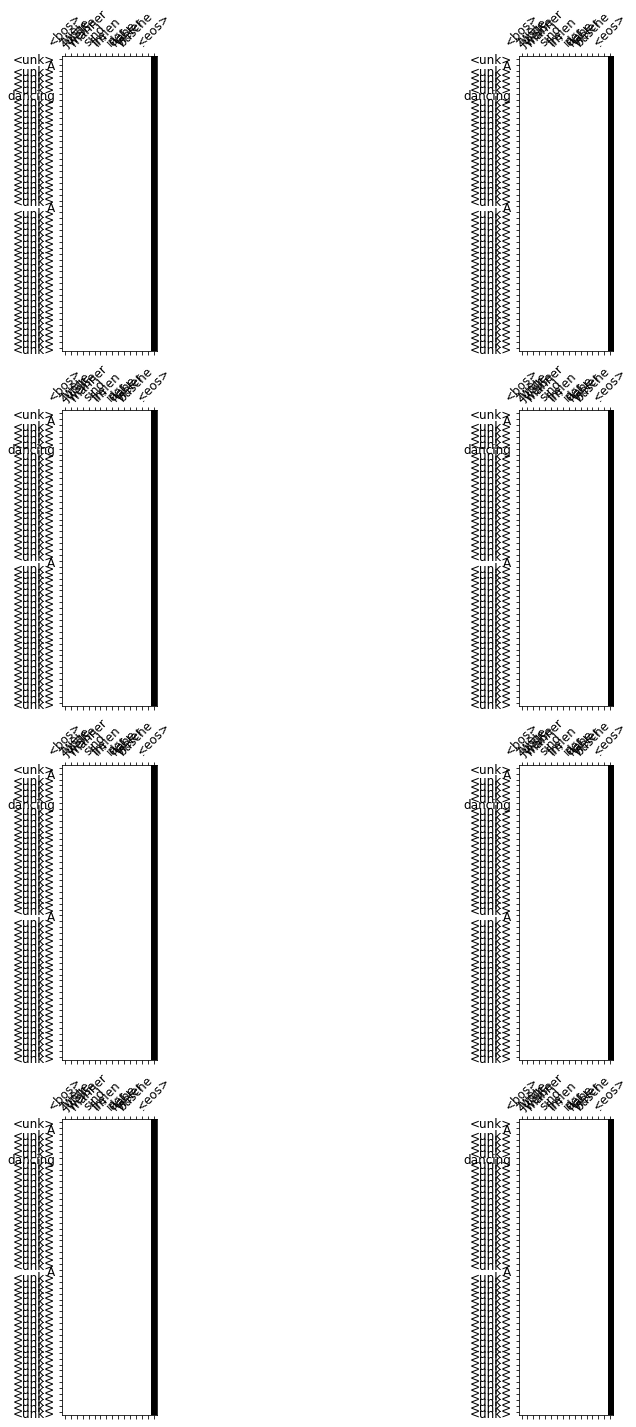

In [84]:
display_attention(src, translation, attention)